In [1]:
import glob
import math
import pathlib

import numpy as np
from tensorflow import keras

from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A

2022-08-24 23:20:15.161674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 23:20:15.161708: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# DataGenerator

In [2]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, augmentation=None, shuffle=False, verbose=0, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        self.augmentation = augmentation
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = np.array(Image.open(f"{source_id}.png"))            
            y = np.array(Image.open(f"{source_id}_labels.png"))
            
            if self.augmentation is not None:
                augmented = self.augmentation(image=x, mask=y)
                x = augmented['image']
                y = augmented['mask']
              
            images.append(x/255.0) # normalize between 0 and 1 at the same time
            labels.append(y)
         
        return np.array(images, dtype=float), np.array(labels, dtype=float)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

## Tests **sans** data-augmentation

In [3]:
batch_size = 4
datapath = pathlib.Path('data','preprocessed','256x128', 'train')
datagen = CustomDataGenerator(datapath, batch_size, shuffle=False, verbose=1)
print("len:", len(datagen))

len: 744


In [4]:
datagen.on_epoch_end()
one_batch_x, one_batch_y = datagen[101]
print(one_batch_x.shape, one_batch_y.shape)

data/preprocessed/256x128/train/aachen_000141_000019
data/preprocessed/256x128/train/strasbourg_000001_019247
data/preprocessed/256x128/train/aachen_000081_000019
data/preprocessed/256x128/train/hanover_000000_012347
(4, 128, 256, 3) (4, 128, 256)


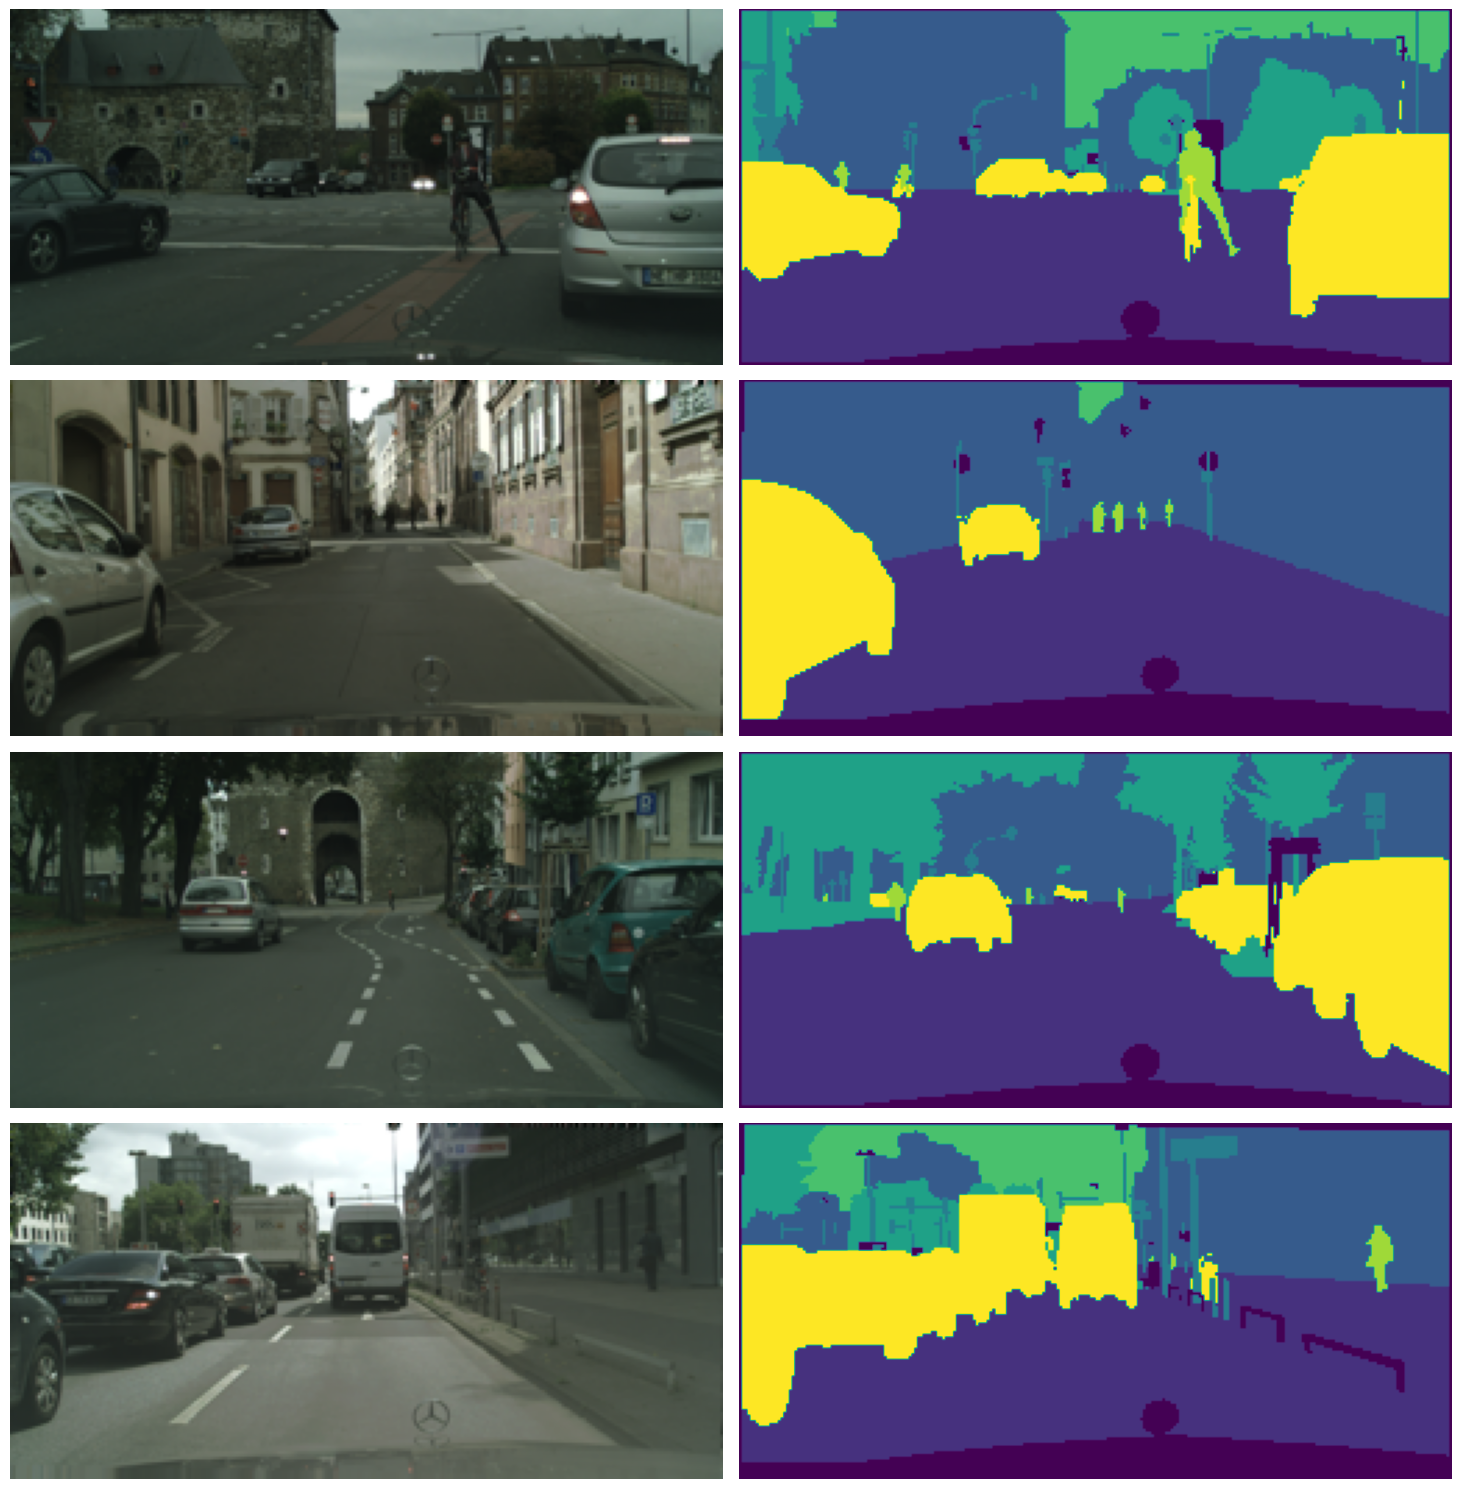

In [5]:
fig = plt.figure(figsize=(15,15))
for i, (img, mask) in enumerate(zip(one_batch_x,one_batch_y)):
    ax = plt.subplot(batch_size, 2, (i*2)+1)
    plt.imshow(img)
    ax.axis('off')
    
    ax = plt.subplot(batch_size, 2, (i*2)+2)
    plt.imshow(mask)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Tests **avec** data-augmentation

>L'augmentation des données est une stratégie qui permet d'accroître de manière significative la diversité des données disponibles pour l'entraînement des modèles (sans collecter de nouvelles données).
>
>Cette technique permet de rendre le modèle plus robuste et d'éviter l'overfitting.
>
> En 2018, Google a publié un article sur AutoAugment (un algorithme qui découvre automatiquement le meilleur ensemble d'augmentations pour le jeu de données). Ils ont montré qu'un ensemble personnalisé d'augmentations améliore les performances du modèle.

In [6]:
transform1 = A.Compose([
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.Rotate(15, p=0.5),
    # A.Transpose(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.01, blur_limit = 3),
])

In [7]:
batch_size = 4
datapath = pathlib.Path('data','preprocessed','256x128', 'train')
datagen = CustomDataGenerator(datapath, batch_size, augmentation=transform1, shuffle=False, verbose=1)
print("len:", len(datagen))

len: 744


In [8]:
datagen.on_epoch_end()
one_batch_x, one_batch_y = datagen[101]
print(one_batch_x.shape, one_batch_y.shape)

data/preprocessed/256x128/train/aachen_000141_000019
data/preprocessed/256x128/train/strasbourg_000001_019247
data/preprocessed/256x128/train/aachen_000081_000019
data/preprocessed/256x128/train/hanover_000000_012347
(4, 128, 256, 3) (4, 128, 256)


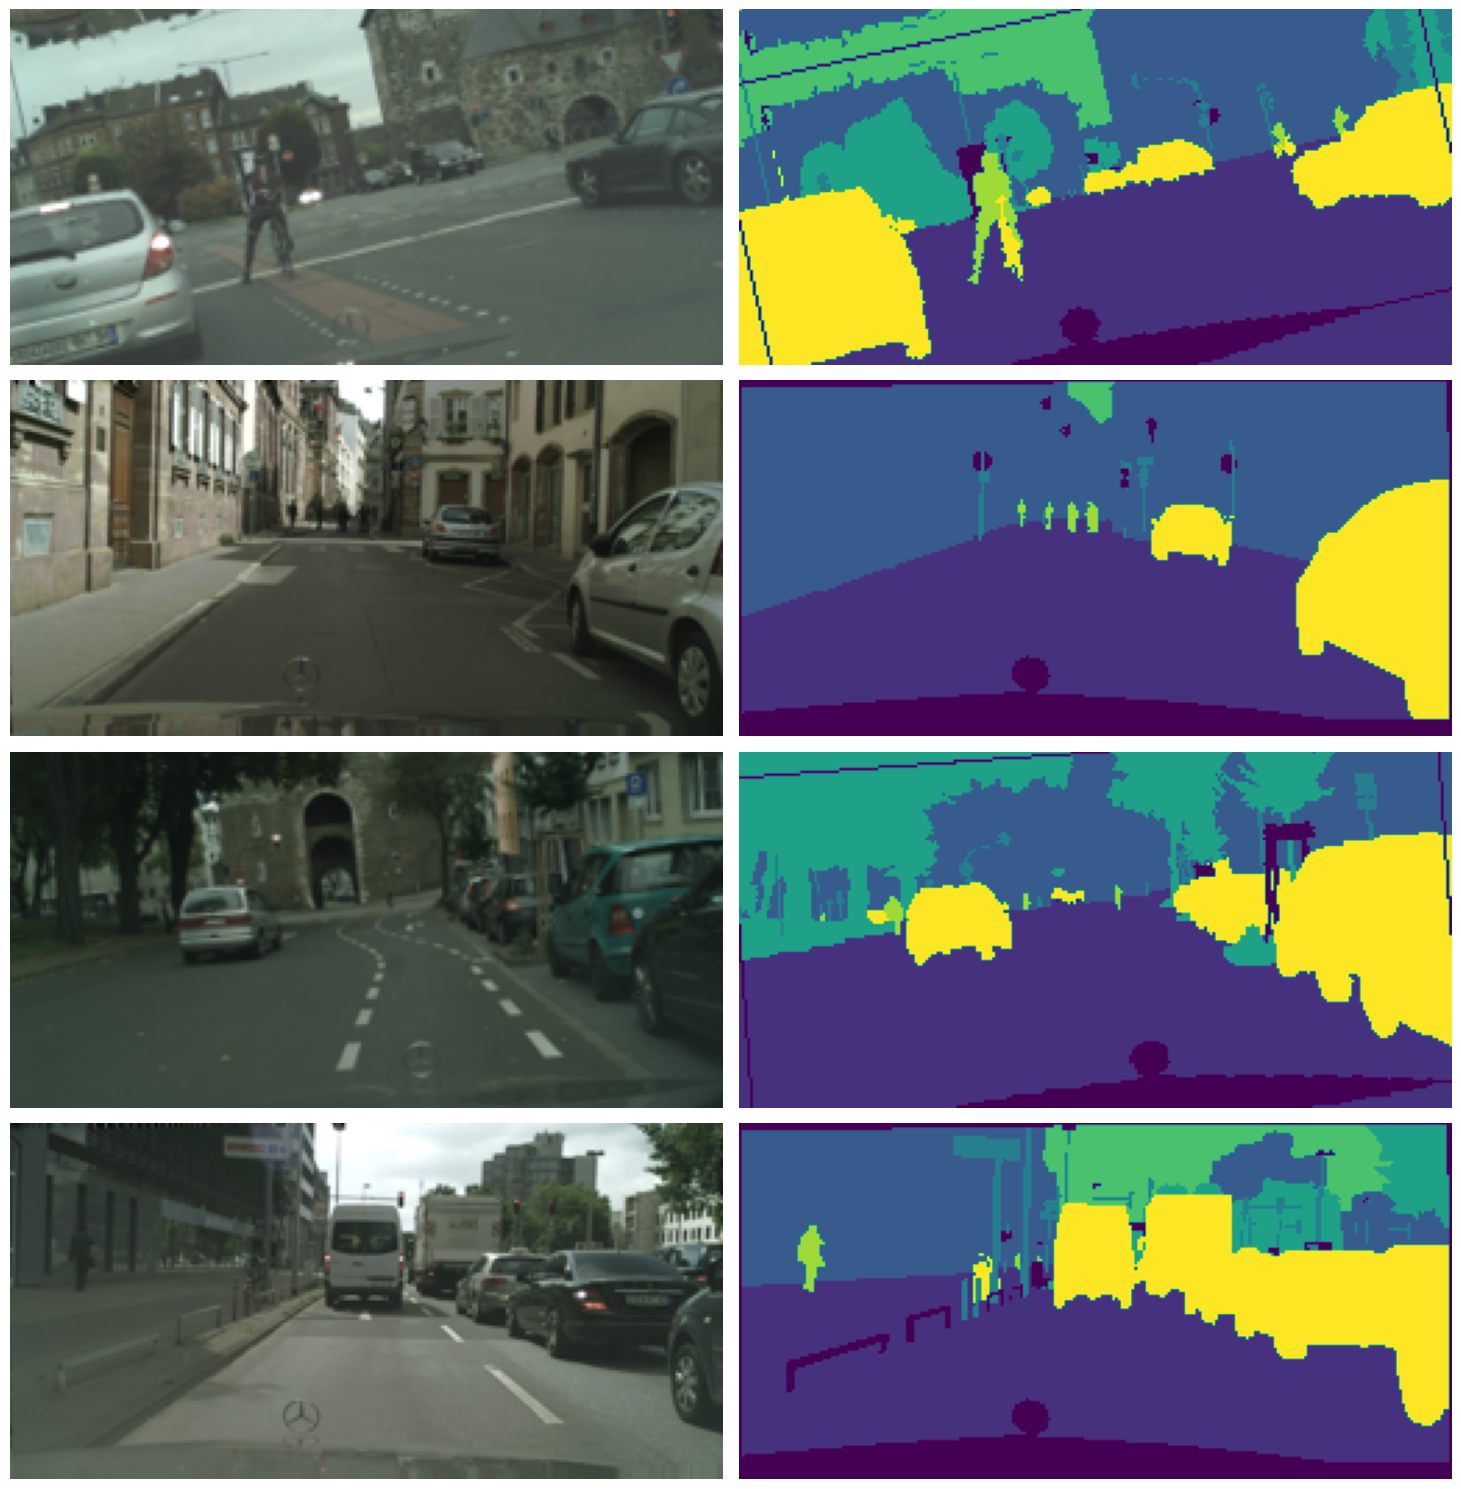

In [9]:
fig = plt.figure(figsize=(15,15))
for i, (img, mask) in enumerate(zip(one_batch_x,one_batch_y)):
    ax = plt.subplot(batch_size, 2, (i*2)+1)
    plt.imshow(img)
    ax.axis('off')
    
    ax = plt.subplot(batch_size, 2, (i*2)+2)
    plt.imshow(mask)
    ax.axis('off')
    
plt.tight_layout()
plt.show()